### Table of Contents


* [Import du jeu de donnée](#chapter0)

* [Préparation des dataframes pour la modelisation](#chapter1)

* [Modelisation](#chapter2)

    * [Tests avec variables numériques](#section1)
    
    * [Tests avec OHE](#section2)
    
    * [Tests avec Label encoding](#section3)
    
    * [Tests avec variables numériques et OHE](#section4)
    
    * [Tests avec variables numériques et label encoding](#section5)
    
    * [Tests avec feature engineering](#section6)

    * [Tests avec energy star score](#section7)    
    
    * [Optimization des hyperparamètres](#section8)

* [Comparaison des resultats](#chapter3)

* [Features importance](#chapter4)


# Import du jeu de donnée <a class="anchor" id="chapter0"></a>

In [61]:
import pandas as pd
import numpy as np

df = pd.read_csv("data.csv", index_col=0)

In [62]:
# drop de la target 2

df = df.drop(["SiteEnergyUseWN(kBtu)"], axis=1)

In [63]:
df.columns

Index(['BuildingType', 'PrimaryPropertyType', 'Neighborhood', 'Latitude',
       'Longitude', 'BuildingAge', 'NumberofFloors', 'PropertyGFATotal',
       'ENERGYSTARScore', 'TotalGHGEmissions', 'haversine_distance',
       'PercentagePerPropertyType'],
      dtype='object')

In [64]:
df.shape

(1610, 12)

In [65]:
df.head()

,BuildingType,PrimaryPropertyType,Neighborhood,Latitude,Longitude,BuildingAge,NumberofFloors,PropertyGFATotal,ENERGYSTARScore,TotalGHGEmissions,haversine_distance,PercentagePerPropertyType
0,NonResidential,Hotel,DOWNTOWN,47.61220,-122.33799,89,12,88434,60.00000,249.98000,0.49678,4.65839
1,NonResidential,Hotel,DOWNTOWN,47.61317,-122.33393,20,11,103566,61.00000,295.86000,0.48873,4.65839
2,NonResidential,Hotel,DOWNTOWN,47.61393,-122.33810,47,41,956110,43.00000,2089.28000,0.60238,4.65839
3,NonResidential,Hotel,DOWNTOWN,47.61412,-122.33664,90,10,61320,56.00000,286.43000,0.58625,4.65839
4,NonResidential,Hotel,DOWNTOWN,47.61375,-122.34047,36,18,175580,75.00000,505.01000,0.65080,4.65839


# Preparation des dataframes pour la modelisation <a class="anchor" id="chapter1"></a>

In [66]:
# creation d'une liste avec les variables numeriques et une liste avec les variables categoriques

objectColumns = list(df.dtypes[df.dtypes == np.object].index)
numericColumns = list(df.dtypes[df.dtypes != np.object].index)
print(objectColumns)
print(numericColumns)

['BuildingType', 'PrimaryPropertyType', 'Neighborhood']
['Latitude', 'Longitude', 'BuildingAge', 'NumberofFloors', 'PropertyGFATotal', 'ENERGYSTARScore', 'TotalGHGEmissions', 'haversine_distance', 'PercentagePerPropertyType']


C:\Users\jean marmoude\AppData\Local\Temp\ipykernel_16612\3436662239.py:3: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  objectColumns = list(df.dtypes[df.dtypes == np.object].index)
C:\Users\jean marmoude\AppData\Local\Temp\ipykernel_16612\3436662239.py:4: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  numericColumns = list(df.dtypes[df.dtypes != np.object].index)


In [67]:
# ohe encoding et creation du dataframe sans energystarscore

df_ohe_wEN = pd.get_dummies(
    df, columns=["BuildingType", "Neighborhood", "PrimaryPropertyType"]
)

# changer le energystar score en int pour la modelisation

df_ohe_noEN = df_ohe_wEN.drop(["ENERGYSTARScore"], axis=1)

df_ohe_wEN = df_ohe_wEN.dropna()

df_ohe_wEN.shape, df_ohe_noEN.shape

((1064, 48), (1610, 47))

In [68]:
# label encoding des variables

from sklearn.preprocessing import LabelEncoder

df_label_wEN = df

# creation du dataframe sans energystarscore

df_label_noEN = df_label_wEN.drop(["ENERGYSTARScore"], axis=1)

df_label_wEN = df_label_wEN.dropna()

le = LabelEncoder()

for feat in objectColumns:
    df_label_wEN[feat] = le.fit_transform(df_label_wEN[feat].astype(str))
    df_label_noEN[feat] = le.fit_transform(df_label_noEN[feat].astype(str))


print(df_label_wEN.info(), df_label_noEN.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1064 entries, 0 to 3371
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   BuildingType               1064 non-null   int32  
 1   PrimaryPropertyType        1064 non-null   int32  
 2   Neighborhood               1064 non-null   int32  
 3   Latitude                   1064 non-null   float64
 4   Longitude                  1064 non-null   float64
 5   BuildingAge                1064 non-null   int64  
 6   NumberofFloors             1064 non-null   int64  
 7   PropertyGFATotal           1064 non-null   int64  
 8   ENERGYSTARScore            1064 non-null   float64
 9   TotalGHGEmissions          1064 non-null   float64
 10  haversine_distance         1064 non-null   float64
 11  PercentagePerPropertyType  1064 non-null   float64
dtypes: float64(6), int32(3), int64(3)
memory usage: 95.6 KB
<class 'pandas.core.frame.DataFrame'>
Int64Index

C:\Users\jean marmoude\AppData\Local\Temp\ipykernel_16612\3013706214.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_label_wEN[feat] = le.fit_transform(df_label_wEN[feat].astype(str))


In [69]:
df_label_wEN["ENERGYSTARScore"] = df_label_wEN["ENERGYSTARScore"].apply(np.int64)
df_ohe_wEN["ENERGYSTARScore"] = df_ohe_wEN["ENERGYSTARScore"].apply(np.int64)

C:\Users\jean marmoude\AppData\Local\Temp\ipykernel_16612\2159347321.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_label_wEN["ENERGYSTARScore"] = df_label_wEN["ENERGYSTARScore"].apply(np.int64)


In [70]:
# drop des na sur les df avec energystar score

df_label_wEN = df_label_wEN.dropna()
df_ohe_wEN = df_ohe_wEN.dropna()

##  Modelisation <a class="anchor" id="chapter1"></a>

In [71]:
from sklearn.linear_model import (
    LinearRegression,
    Lasso,
    Ridge,
    SGDRegressor,
    ElasticNet,
)
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from xgboost import *

from sklearn.model_selection import (
    train_test_split,
    StratifiedShuffleSplit,
    GridSearchCV,
)
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RepeatedKFold

from sklearn.preprocessing import *
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.metrics import *

from numpy import arange

import time

# Modélisation <a class="anchor" id="chapter2"></a> 

### Tests avec variables numériques <a class="anchor" id="section1"></a> 

In [72]:
# test 1 : avec 'PropertyGFATotal'

y_columns = ["TotalGHGEmissions"]
X = df[["PropertyGFATotal"]]
y = df["TotalGHGEmissions"]

print(X.shape)
print(y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

results1 = []

(1610, 1)
(1610,)


In [73]:
algos = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(),
    "Lasso": Lasso(tol=0.5),
    "ElasticNet": ElasticNet(),
    "SGDRegressor": SGDRegressor(),
    "SVR": SVR(),
    "RandomForestRegressor": RandomForestRegressor(),
    "XGBRegressor": XGBRegressor(),
}

for algo_name, algo in algos.items():
    for column in y_columns:
        start_of_f1 = time.time()
        model = make_pipeline(algo)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        train = model.score(X_train, y_train)
        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)
        results1.append([algo_name, mae, rmse, r2])

data_num = pd.DataFrame(results1, columns=["algo", "mae", "rmse", "r2"])
data_num["algo"] = "data_num_" + data_num["algo"].astype(str)
pd.set_option("display.float_format", lambda x: "%.5f" % x)
data_num

,algo,mae,rmse,r2
0,data_num_LinearRegression,168.61928,596.51837,0.17867
1,data_num_Ridge,168.61928,596.51837,0.17867
2,data_num_Lasso,168.61928,596.51837,0.17867
3,data_num_ElasticNet,168.61928,596.51837,0.17867
4,data_num_SGDRegressor,6422744295808218112.00000,13476587728766001152.00000,-419209700131266160945613389168640.00000
5,data_num_SVR,132.66137,656.13995,0.00628
6,data_num_RandomForestRegressor,224.72618,986.41893,-1.24592
7,data_num_XGBRegressor,235.11374,1260.92638,-2.66987


In [74]:
# test 2 : avec 'NumberofFloors'

X = df[["NumberofFloors"]]
y = df["TotalGHGEmissions"]

print(X.shape)
print(y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

results2 = []

algos = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(),
    "Lasso": Lasso(tol=0.5),
    "ElasticNet": ElasticNet(),
    "SGDRegressor": SGDRegressor(),
    "SVR": SVR(),
    "RandomForestRegressor": RandomForestRegressor(),
    "XGBRegressor": XGBRegressor(),
}

for algo_name, algo in algos.items():
    for column in y_columns:
        start_of_f1 = time.time()
        model = make_pipeline(algo)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        train = model.score(X_train, y_train)
        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)
        results2.append([algo_name, r2])

data_NumberofFloors = pd.DataFrame(results2, columns=["algo", "r2"])
data_NumberofFloors["algo"] = "data_NumberofFloors_" + data_NumberofFloors[
    "algo"
].astype(str)
pd.set_option("display.float_format", lambda x: "%.5f" % x)
data_NumberofFloors

(1610, 1)
(1610,)


,algo,r2
0,data_NumberofFloors_LinearRegression,0.02611
1,data_NumberofFloors_Ridge,0.02611
2,data_NumberofFloors_Lasso,0.02612
3,data_NumberofFloors_ElasticNet,0.02615
4,data_NumberofFloors_SGDRegressor,-0.03749
5,data_NumberofFloors_SVR,-0.01368
6,data_NumberofFloors_RandomForestRegressor,-0.01671
7,data_NumberofFloors_XGBRegressor,-0.02638


In [75]:
# test 3 : avec 'BuildingAge'

X = df[["BuildingAge"]]
y = df["TotalGHGEmissions"]

print(X.shape)
print(y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

results3 = []

algos = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(),
    "Lasso": Lasso(tol=0.5),
    "ElasticNet": ElasticNet(),
    "SGDRegressor": SGDRegressor(),
    "SVR": SVR(),
    "RandomForestRegressor": RandomForestRegressor(),
    "XGBRegressor": XGBRegressor(),
}

for algo_name, algo in algos.items():
    for column in y_columns:
        start_of_f1 = time.time()
        model = make_pipeline(algo)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        train = model.score(X_train, y_train)
        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)
        results3.append([algo_name, r2])

data_BuildingAge = pd.DataFrame(results3, columns=["algo", "r2"])
data_BuildingAge["algo"] = "data_BuildingAge_" + data_BuildingAge["algo"].astype(str)
pd.set_option("display.float_format", lambda x: "%.5f" % x)
data_BuildingAge

(1610, 1)
(1610,)


,algo,r2
0,data_BuildingAge_LinearRegression,0.00440
1,data_BuildingAge_Ridge,0.00440
2,data_BuildingAge_Lasso,0.00440
3,data_BuildingAge_ElasticNet,0.00440
4,data_BuildingAge_SGDRegressor,-154936559240513952.00000
5,data_BuildingAge_SVR,-0.02793
6,data_BuildingAge_RandomForestRegressor,-0.12589
7,data_BuildingAge_XGBRegressor,-0.16767


In [76]:
# test 4 : avec l'ensemble des variables numeriques

X = df[["PropertyGFATotal", "NumberofFloors", "BuildingAge"]]
y = df["TotalGHGEmissions"]

print(X.shape)
print(y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

results4 = []

algos = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(),
    "Lasso": Lasso(tol=0.5),
    "ElasticNet": ElasticNet(),
    "SGDRegressor": SGDRegressor(),
    "SVR": SVR(),
    "RandomForestRegressor": RandomForestRegressor(),
    "XGBRegressor": XGBRegressor(),
}

for algo_name, algo in algos.items():
    for column in y_columns:
        start_of_f1 = time.time()
        model = make_pipeline(algo)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        train = model.score(X_train, y_train)
        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)
        results4.append([algo_name, r2])

data_num = pd.DataFrame(results4, columns=["algo", "r2"])
data_num["algo"] = "data_num_" + data_num["algo"].astype(str)
pd.set_option("display.float_format", lambda x: "%.5f" % x)
data_num

(1610, 3)
(1610,)


,algo,r2
0,data_num_LinearRegression,0.25523
1,data_num_Ridge,0.25523
2,data_num_Lasso,0.24830
3,data_num_ElasticNet,0.25408
4,data_num_SGDRegressor,-669598537849569740687742028742656.00000
5,data_num_SVR,0.00634
6,data_num_RandomForestRegressor,-0.63704
7,data_num_XGBRegressor,-1.98516


In [77]:
'''''

    Observations:

     - La variable PropertyGFAtotale semble etre la plus importante dans notre modélisation
     - L'age du batiment 'buildingAge' performe mal
     - les méthodes non ensemblistes performent le mieux
     - Le SGD Regressor performe très mal 
     
'''''

"''\n\n    Observations:\n\n     - La variable PropertyGFAtotale semble etre la plus importante dans notre modélisation\n     - L'age du batiment 'buildingAge' performe mal\n     - les méthodes non ensemblistes performent le mieux\n     - Le SGD Regressor performe très mal \n     \n"

### Tests avec OH Encodage <a class="anchor" id="section2"></a> 

In [78]:
# test 5 : avec variables ohe encodage sur 'BuildingType'

X = df_ohe_noEN[
    [
        "BuildingType_Campus",
        "BuildingType_NonResidential",
        "BuildingType_Nonresidential COS",
        "BuildingType_Nonresidential WA",
        "BuildingType_SPS-District K-12",
    ]
]
y = df_ohe_noEN["TotalGHGEmissions"]

print(X.shape)
print(y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

results5 = []

algos = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(),
    "Lasso": Lasso(tol=0.5),
    "ElasticNet": ElasticNet(),
    "SGDRegressor": SGDRegressor(),
    "SVR": SVR(),
    "RandomForestRegressor": RandomForestRegressor(),
    "XGBRegressor": XGBRegressor(),
}

for algo_name, algo in algos.items():
    for column in y_columns:
        start_of_f1 = time.time()
        model = make_pipeline(algo)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        train = model.score(X_train, y_train)
        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)
        results5.append([algo_name, r2])

data_ohe_building = pd.DataFrame(results5, columns=["algo", "r2"])
data_ohe_building["algo"] = "data_ohe_building_" + data_ohe_building["algo"].astype(str)
pd.set_option("display.float_format", lambda x: "%.5f" % x)
data_ohe_building

(1610, 5)
(1610,)


,algo,r2
0,data_ohe_building_LinearRegression,-0.03370
1,data_ohe_building_Ridge,-0.03121
2,data_ohe_building_Lasso,-0.03140
3,data_ohe_building_ElasticNet,-0.00175
4,data_ohe_building_SGDRegressor,-0.02408
5,data_ohe_building_SVR,-0.03119
6,data_ohe_building_RandomForestRegressor,-0.02887
7,data_ohe_building_XGBRegressor,-0.03370


In [79]:
# test 6 : avec variables ohe encodage sur 'Neighborhood'

X = df_ohe_noEN[
    [
        "Neighborhood_BALLARD",
        "Neighborhood_CENTRAL",
        "Neighborhood_DELRIDGE",
        "Neighborhood_DOWNTOWN",
        "Neighborhood_EAST",
        "Neighborhood_GREATER DUWAMISH",
        "Neighborhood_LAKE UNION",
        "Neighborhood_MAGNOLIA / QUEEN ANNE",
        "Neighborhood_NORTH",
        "Neighborhood_NORTHEAST",
        "Neighborhood_NORTHWEST",
        "Neighborhood_SOUTHEAST",
        "Neighborhood_SOUTHWEST",
    ]
]
y = df_ohe_noEN["TotalGHGEmissions"]

print(X.shape)
print(y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

results6 = []

algos = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(),
    "Lasso": Lasso(tol=0.5),
    "ElasticNet": ElasticNet(),
    "SGDRegressor": SGDRegressor(),
    "SVR": SVR(),
    "RandomForestRegressor": RandomForestRegressor(),
    "XGBRegressor": XGBRegressor(),
}

for algo_name, algo in algos.items():
    for column in y_columns:
        start_of_f1 = time.time()
        model = make_pipeline(algo)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        train = model.score(X_train, y_train)
        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)
        results6.append([algo_name, r2])

data_ohe_neighbor = pd.DataFrame(results6, columns=["algo", "r2"])
data_ohe_neighbor["algo"] = "data_ohe_neighbor_" + data_ohe_neighbor["algo"].astype(str)
pd.set_option("display.float_format", lambda x: "%.5f" % x)
data_ohe_neighbor

(1610, 13)
(1610,)


,algo,r2
0,data_ohe_neighbor_LinearRegression,0.04225
1,data_ohe_neighbor_Ridge,0.04093
2,data_ohe_neighbor_Lasso,0.04091
3,data_ohe_neighbor_ElasticNet,0.00659
4,data_ohe_neighbor_SGDRegressor,0.04102
5,data_ohe_neighbor_SVR,-0.02372
6,data_ohe_neighbor_RandomForestRegressor,0.03567
7,data_ohe_neighbor_XGBRegressor,0.04117


In [80]:
# test 7 : avec variables ohe encodage sur PrimaryPropertyType

X = df_ohe_noEN[
    [
        "PrimaryPropertyType_Distribution Center",
        "PrimaryPropertyType_Hospital",
        "PrimaryPropertyType_Hotel",
        "PrimaryPropertyType_K-12 School",
        "PrimaryPropertyType_Laboratory",
        "PrimaryPropertyType_Large Office",
        "PrimaryPropertyType_Medical Office",
        "PrimaryPropertyType_Mixed Use Property",
        "PrimaryPropertyType_Office",
        "PrimaryPropertyType_Other",
        "PrimaryPropertyType_Refrigerated Warehouse",
        "PrimaryPropertyType_Residence Hall",
        "PrimaryPropertyType_Restaurant",
        "PrimaryPropertyType_Retail Store",
        "PrimaryPropertyType_Self-Storage Facility",
        "PrimaryPropertyType_Senior Care Community",
        "PrimaryPropertyType_Small- and Mid-Sized Office",
        "PrimaryPropertyType_Supermarket / Grocery Store",
        "PrimaryPropertyType_University",
        "PrimaryPropertyType_Warehouse",
        "PrimaryPropertyType_Worship Facility",
    ]
]
y = df_ohe_noEN["TotalGHGEmissions"]

print(X.shape)
print(y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

results7 = []

algos = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(),
    "Lasso": Lasso(tol=0.5),
    "ElasticNet": ElasticNet(),
    "SGDRegressor": SGDRegressor(),
    "SVR": SVR(),
    "RandomForestRegressor": RandomForestRegressor(),
    "XGBRegressor": XGBRegressor(),
}

for algo_name, algo in algos.items():
    for column in y_columns:
        start_of_f1 = time.time()
        model = make_pipeline(algo)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        train = model.score(X_train, y_train)
        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)
        results7.append([algo_name, r2])

data_ohe_prim_property_type = pd.DataFrame(results7, columns=["algo", "r2"])
data_ohe_prim_property_type[
    "algo"
] = "data_ohe_prim_property_type_" + data_ohe_prim_property_type["algo"].astype(str)
pd.set_option("display.float_format", lambda x: "%.5f" % x)
data_ohe_prim_property_type

(1610, 21)
(1610,)


,algo,r2
0,data_ohe_prim_property_type_LinearRegression,0.33050
1,data_ohe_prim_property_type_Ridge,0.35350
2,data_ohe_prim_property_type_Lasso,0.34118
3,data_ohe_prim_property_type_ElasticNet,0.01477
4,data_ohe_prim_property_type_SGDRegressor,0.34682
5,data_ohe_prim_property_type_SVR,-0.02026
6,data_ohe_prim_property_type_RandomForestRegressor,0.32640
7,data_ohe_prim_property_type_XGBRegressor,0.33044


In [81]:
# test 8 : avec variables categoriques ohe encodées

X = df_ohe_noEN[
    [
        "BuildingType_Campus",
        "BuildingType_NonResidential",
        "BuildingType_Nonresidential COS",
        "BuildingType_Nonresidential WA",
        "BuildingType_SPS-District K-12",
        "Neighborhood_BALLARD",
        "Neighborhood_CENTRAL",
        "Neighborhood_DELRIDGE",
        "Neighborhood_DOWNTOWN",
        "Neighborhood_EAST",
        "Neighborhood_GREATER DUWAMISH",
        "Neighborhood_LAKE UNION",
        "Neighborhood_MAGNOLIA / QUEEN ANNE",
        "Neighborhood_NORTH",
        "Neighborhood_NORTHEAST",
        "Neighborhood_NORTHWEST",
        "Neighborhood_SOUTHEAST",
        "Neighborhood_SOUTHWEST",
        "PrimaryPropertyType_Distribution Center",
        "PrimaryPropertyType_Hospital",
        "PrimaryPropertyType_Hotel",
        "PrimaryPropertyType_K-12 School",
        "PrimaryPropertyType_Laboratory",
        "PrimaryPropertyType_Large Office",
        "PrimaryPropertyType_Medical Office",
        "PrimaryPropertyType_Mixed Use Property",
        "PrimaryPropertyType_Office",
        "PrimaryPropertyType_Other",
        "PrimaryPropertyType_Refrigerated Warehouse",
        "PrimaryPropertyType_Residence Hall",
        "PrimaryPropertyType_Restaurant",
        "PrimaryPropertyType_Retail Store",
        "PrimaryPropertyType_Self-Storage Facility",
        "PrimaryPropertyType_Senior Care Community",
        "PrimaryPropertyType_Small- and Mid-Sized Office",
        "PrimaryPropertyType_Supermarket / Grocery Store",
        "PrimaryPropertyType_University",
        "PrimaryPropertyType_Warehouse",
        "PrimaryPropertyType_Worship Facility",
    ]
]
y = df_ohe_noEN["TotalGHGEmissions"]

print(X.shape)
print(y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

results8 = []

algos = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(),
    "Lasso": Lasso(tol=0.5),
    "ElasticNet": ElasticNet(),
    "SGDRegressor": SGDRegressor(),
    "SVR": SVR(),
    "RandomForestRegressor": RandomForestRegressor(),
    "XGBRegressor": XGBRegressor(),
}

for algo_name, algo in algos.items():
    for column in y_columns:
        start_of_f1 = time.time()
        model = make_pipeline(algo)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        train = model.score(X_train, y_train)
        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)
        results8.append([algo_name, r2])

data_ohe = pd.DataFrame(results8, columns=["algo", "r2"])
data_ohe["algo"] = "data_ohe_" + data_ohe["algo"].astype(str)
pd.set_option("display.float_format", lambda x: "%.5f" % x)
data_ohe

(1610, 39)
(1610,)


,algo,r2
0,data_ohe_LinearRegression,0.31270
1,data_ohe_Ridge,0.34464
2,data_ohe_Lasso,0.32827
3,data_ohe_ElasticNet,0.02084
4,data_ohe_SGDRegressor,0.34552
5,data_ohe_SVR,-0.02205
6,data_ohe_RandomForestRegressor,0.58211
7,data_ohe_XGBRegressor,0.59205


In [82]:
'''''

    Observations:

     - La variable PrimaryPropretytype semble etre la plus importante dans notre modélisation
     - Le type de propriété 'buildingtype' performe très mal, perte de performance sur les méthodes linéaires
     - les méthodes ensemblistes performent le mieux
     - Le SGD Regressor performe très mal
     
'''''

"''\n\n    Observations:\n\n     - La variable PrimaryPropretytype semble etre la plus importante dans notre modélisation\n     - Le type de propriété 'buildingtype' performe très mal, perte de performance sur les méthodes linéaires\n     - les méthodes ensemblistes performent le mieux\n     - Le SGD Regressor performe très mal\n     \n"

### Tests avec Label Encodage <a class="anchor" id="section3"></a> 

In [83]:
# test 9 : avec variables label encodage 'BuildingType'

X = df_label_noEN[["BuildingType"]]
y = df_ohe_noEN["TotalGHGEmissions"]

print(X.shape)
print(y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

results9 = []

algos = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(),
    "Lasso": Lasso(tol=0.5),
    "ElasticNet": ElasticNet(),
    "SGDRegressor": SGDRegressor(),
    "SVR": SVR(),
    "RandomForestRegressor": RandomForestRegressor(),
    "XGBRegressor": XGBRegressor(),
}

for algo_name, algo in algos.items():
    for column in y_columns:
        start_of_f1 = time.time()
        model = make_pipeline(algo)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        train = model.score(X_train, y_train)
        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)
        results9.append([algo_name, r2])

data_label_buildingtype = pd.DataFrame(results9, columns=["algo", "r2"])
data_label_buildingtype["algo"] = "data_label_buildingtype_" + data_label_buildingtype[
    "algo"
].astype(str)
pd.set_option("display.float_format", lambda x: "%.5f" % x)
data_label_buildingtype

(1610, 1)
(1610,)


,algo,r2
0,data_label_buildingtype_LinearRegression,-0.00376
1,data_label_buildingtype_Ridge,-0.00374
2,data_label_buildingtype_Lasso,-0.00344
3,data_label_buildingtype_ElasticNet,0.00002
4,data_label_buildingtype_SGDRegressor,-0.00279
5,data_label_buildingtype_SVR,-0.03118
6,data_label_buildingtype_RandomForestRegressor,-0.03451
7,data_label_buildingtype_XGBRegressor,-0.03370


In [84]:
# test 10 : avec variables label encodage 'PrimaryPropertyType'

X = df_label_noEN[["PrimaryPropertyType"]]
y = df_ohe_noEN["TotalGHGEmissions"]

print(X.shape)
print(y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

results10 = []

algos = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(),
    "Lasso": Lasso(tol=0.5),
    "ElasticNet": ElasticNet(),
    "SGDRegressor": SGDRegressor(),
    "SVR": SVR(),
    "RandomForestRegressor": RandomForestRegressor(),
    "XGBRegressor": XGBRegressor(),
}

for algo_name, algo in algos.items():
    for column in y_columns:
        start_of_f1 = time.time()
        model = make_pipeline(algo)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        train = model.score(X_train, y_train)
        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)
        results10.append([algo_name, r2])

data_label_PrimaryPropertyType = pd.DataFrame(results10, columns=["algo", "r2"])
data_label_PrimaryPropertyType[
    "algo"
] = "data_label_PrimaryPropertyType_" + data_label_PrimaryPropertyType["algo"].astype(
    str
)
pd.set_option("display.float_format", lambda x: "%.5f" % x)
data_label_PrimaryPropertyType

(1610, 1)
(1610,)


,algo,r2
0,data_label_PrimaryPropertyType_LinearRegression,0.02522
1,data_label_PrimaryPropertyType_Ridge,0.02522
2,data_label_PrimaryPropertyType_Lasso,0.02523
3,data_label_PrimaryPropertyType_ElasticNet,0.02523
4,data_label_PrimaryPropertyType_SGDRegressor,0.00724
5,data_label_PrimaryPropertyType_SVR,-0.01837
6,data_label_PrimaryPropertyType_RandomForestReg...,0.33545
7,data_label_PrimaryPropertyType_XGBRegressor,0.33044


In [85]:
# test 11 : avec variables label encodage 'Neighborhood'

X = df_label_noEN[["Neighborhood"]]
y = df_ohe_noEN["TotalGHGEmissions"]

print(X.shape)
print(y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

results11 = []

algos = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(),
    "Lasso": Lasso(tol=0.5),
    "ElasticNet": ElasticNet(),
    "SGDRegressor": SGDRegressor(),
    "SVR": SVR(),
    "RandomForestRegressor": RandomForestRegressor(),
    "XGBRegressor": XGBRegressor(),
}

for algo_name, algo in algos.items():
    for column in y_columns:
        start_of_f1 = time.time()
        model = make_pipeline(algo)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        train = model.score(X_train, y_train)
        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)
        results11.append([algo_name, r2])

data_label_Neighborhood = pd.DataFrame(results11, columns=["algo", "r2"])
data_label_Neighborhood["algo"] = "data_label_Neighborhood_" + data_label_Neighborhood[
    "algo"
].astype(str)
pd.set_option("display.float_format", lambda x: "%.5f" % x)
data_label_Neighborhood

(1610, 1)
(1610,)


,algo,r2
0,data_label_Neighborhood_LinearRegression,0.00156
1,data_label_Neighborhood_Ridge,0.00156
2,data_label_Neighborhood_Lasso,0.00151
3,data_label_Neighborhood_ElasticNet,0.00142
4,data_label_Neighborhood_SGDRegressor,0.00422
5,data_label_Neighborhood_SVR,-0.02737
6,data_label_Neighborhood_RandomForestRegressor,0.04279
7,data_label_Neighborhood_XGBRegressor,0.04117


In [86]:
# test 12 : avec variables catégoriques label encodage

X = df_label_noEN[["BuildingType", "PrimaryPropertyType", "Neighborhood"]]
y = df_ohe_noEN["TotalGHGEmissions"]

print(X.shape)
print(y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

results12 = []

algos = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(),
    "Lasso": Lasso(tol=0.5),
    "ElasticNet": ElasticNet(),
    "SGDRegressor": SGDRegressor(),
    "SVR": SVR(),
    "RandomForestRegressor": RandomForestRegressor(),
    "XGBRegressor": XGBRegressor(),
}

for algo_name, algo in algos.items():
    for column in y_columns:
        start_of_f1 = time.time()
        model = make_pipeline(algo)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        train = model.score(X_train, y_train)
        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)
        results12.append([algo_name, r2])

data_label = pd.DataFrame(results12, columns=["algo", "r2"])
data_label["algo"] = "data_label_Neighborhood_" + data_label["algo"].astype(str)
pd.set_option("display.float_format", lambda x: "%.5f" % x)
data_label

(1610, 3)
(1610,)


,algo,r2
0,data_label_Neighborhood_LinearRegression,0.02702
1,data_label_Neighborhood_Ridge,0.02706
2,data_label_Neighborhood_Lasso,0.02845
3,data_label_Neighborhood_ElasticNet,0.03275
4,data_label_Neighborhood_SGDRegressor,0.02748
5,data_label_Neighborhood_SVR,-0.01592
6,data_label_Neighborhood_RandomForestRegressor,0.61280
7,data_label_Neighborhood_XGBRegressor,0.64126


In [87]:
'''''

    Observations:

     - A part pour les méthodes ensemblistes, performe moins bien que l'encodage OHE
     - Le type de propriété 'buildingtype' performe très mal, perte de performance sur les méthodes linéaires
     - les méthodes ensemblistes performent le mieux
     
'''''

"''\n\n    Observations:\n\n     - A part pour les méthodes ensemblistes, performe moins bien que l'encodage OHE\n     - Le type de propriété 'buildingtype' performe très mal, perte de performance sur les méthodes linéaires\n     - les méthodes ensemblistes performent le mieux\n     \n"

### Tests avec variables numériques et OHE <a class="anchor" id="section4"></a>  

In [88]:
# test 13 avec Primary propertytype encodé OHE et propertyGFAtotal

X = df_ohe_noEN[
    [
        "PropertyGFATotal",
        "PrimaryPropertyType_Distribution Center",
        "PrimaryPropertyType_Hospital",
        "PrimaryPropertyType_Hotel",
        "PrimaryPropertyType_K-12 School",
        "PrimaryPropertyType_Laboratory",
        "PrimaryPropertyType_Large Office",
        "PrimaryPropertyType_Medical Office",
        "PrimaryPropertyType_Mixed Use Property",
        "PrimaryPropertyType_Office",
        "PrimaryPropertyType_Other",
        "PrimaryPropertyType_Refrigerated Warehouse",
        "PrimaryPropertyType_Residence Hall",
        "PrimaryPropertyType_Restaurant",
        "PrimaryPropertyType_Retail Store",
        "PrimaryPropertyType_Self-Storage Facility",
        "PrimaryPropertyType_Senior Care Community",
        "PrimaryPropertyType_Small- and Mid-Sized Office",
        "PrimaryPropertyType_Supermarket / Grocery Store",
        "PrimaryPropertyType_University",
        "PrimaryPropertyType_Warehouse",
        "PrimaryPropertyType_Worship Facility",
    ]
]
y = df_ohe_noEN["TotalGHGEmissions"]

print(X.shape)
print(y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

results13 = []

algos = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(),
    "Lasso": Lasso(tol=0.5),
    "ElasticNet": ElasticNet(),
    "SGDRegressor": SGDRegressor(),
    "SVR": SVR(),
    "RandomForestRegressor": RandomForestRegressor(),
    "XGBRegressor": XGBRegressor(),
}

for algo_name, algo in algos.items():
    for column in y_columns:
        start_of_f1 = time.time()
        model = make_pipeline(algo)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        train = model.score(X_train, y_train)
        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)
        results13.append([algo_name, r2])

data_ohe_PrimProp_GFA = pd.DataFrame(results13, columns=["algo", "r2"])
data_ohe_PrimProp_GFA["algo"] = "data_ohe_PrimProp_GFA_" + data_ohe_PrimProp_GFA[
    "algo"
].astype(str)
pd.set_option("display.float_format", lambda x: "%.5f" % x)
data_ohe_PrimProp_GFA

(1610, 22)
(1610,)


,algo,r2
0,data_ohe_PrimProp_GFA_LinearRegression,0.47304
1,data_ohe_PrimProp_GFA_Ridge,0.48775
2,data_ohe_PrimProp_GFA_Lasso,0.48189
3,data_ohe_PrimProp_GFA_ElasticNet,0.19872
4,data_ohe_PrimProp_GFA_SGDRegressor,-84288950189023547672246999255613440.00000
5,data_ohe_PrimProp_GFA_SVR,0.00623
6,data_ohe_PrimProp_GFA_RandomForestRegressor,0.28129
7,data_ohe_PrimProp_GFA_XGBRegressor,-0.23479


In [89]:
# test 14 avec Primary propertytype encodé OHE, propertyGFAtotal et Numberoffloors

X = df_ohe_noEN[
    [
        "NumberofFloors",
        "PropertyGFATotal",
        "PrimaryPropertyType_Distribution Center",
        "PrimaryPropertyType_Hospital",
        "PrimaryPropertyType_Hotel",
        "PrimaryPropertyType_K-12 School",
        "PrimaryPropertyType_Laboratory",
        "PrimaryPropertyType_Large Office",
        "PrimaryPropertyType_Medical Office",
        "PrimaryPropertyType_Mixed Use Property",
        "PrimaryPropertyType_Office",
        "PrimaryPropertyType_Other",
        "PrimaryPropertyType_Refrigerated Warehouse",
        "PrimaryPropertyType_Residence Hall",
        "PrimaryPropertyType_Restaurant",
        "PrimaryPropertyType_Retail Store",
        "PrimaryPropertyType_Self-Storage Facility",
        "PrimaryPropertyType_Senior Care Community",
        "PrimaryPropertyType_Small- and Mid-Sized Office",
        "PrimaryPropertyType_Supermarket / Grocery Store",
        "PrimaryPropertyType_University",
        "PrimaryPropertyType_Warehouse",
        "PrimaryPropertyType_Worship Facility",
    ]
]
y = df_ohe_noEN["TotalGHGEmissions"]

print(X.shape)
print(y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

results14 = []

algos = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(),
    "Lasso": Lasso(tol=0.5),
    "ElasticNet": ElasticNet(),
    "SGDRegressor": SGDRegressor(),
    "SVR": SVR(),
    "RandomForestRegressor": RandomForestRegressor(),
    "XGBRegressor": XGBRegressor(),
}

for algo_name, algo in algos.items():
    for column in y_columns:
        start_of_f1 = time.time()
        model = make_pipeline(algo)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        train = model.score(X_train, y_train)
        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)
        results14.append([algo_name, r2])

data_ohe_PrimProp_GFA_floors = pd.DataFrame(results14, columns=["algo", "r2"])
data_ohe_PrimProp_GFA_floors[
    "algo"
] = "data_ohe_PrimProp_GFA_floors_" + data_ohe_PrimProp_GFA_floors["algo"].astype(str)
pd.set_option("display.float_format", lambda x: "%.5f" % x)
data_ohe_PrimProp_GFA_floors

(1610, 23)
(1610,)


,algo,r2
0,data_ohe_PrimProp_GFA_floors_LinearRegression,0.49371
1,data_ohe_PrimProp_GFA_floors_Ridge,0.51037
2,data_ohe_PrimProp_GFA_floors_Lasso,0.48161
3,data_ohe_PrimProp_GFA_floors_ElasticNet,0.26689
4,data_ohe_PrimProp_GFA_floors_SGDRegressor,-32521078023031294451226186350592.00000
5,data_ohe_PrimProp_GFA_floors_SVR,0.00623
6,data_ohe_PrimProp_GFA_floors_RandomForestRegre...,0.14015
7,data_ohe_PrimProp_GFA_floors_XGBRegressor,-0.24804


In [90]:
# test 15 avec Primary propertytype encodé OHE, variable numeriques

X = df_ohe_noEN[
    [
        "BuildingAge",
        "NumberofFloors",
        "PropertyGFATotal",
        "PrimaryPropertyType_Distribution Center",
        "PrimaryPropertyType_Hospital",
        "PrimaryPropertyType_Hotel",
        "PrimaryPropertyType_K-12 School",
        "PrimaryPropertyType_Laboratory",
        "PrimaryPropertyType_Large Office",
        "PrimaryPropertyType_Medical Office",
        "PrimaryPropertyType_Mixed Use Property",
        "PrimaryPropertyType_Office",
        "PrimaryPropertyType_Other",
        "PrimaryPropertyType_Refrigerated Warehouse",
        "PrimaryPropertyType_Residence Hall",
        "PrimaryPropertyType_Restaurant",
        "PrimaryPropertyType_Retail Store",
        "PrimaryPropertyType_Self-Storage Facility",
        "PrimaryPropertyType_Senior Care Community",
        "PrimaryPropertyType_Small- and Mid-Sized Office",
        "PrimaryPropertyType_Supermarket / Grocery Store",
        "PrimaryPropertyType_University",
        "PrimaryPropertyType_Warehouse",
        "PrimaryPropertyType_Worship Facility",
    ]
]
y = df_ohe_noEN["TotalGHGEmissions"]

print(X.shape)
print(y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

results15 = []

algos = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(),
    "Lasso": Lasso(tol=0.5),
    "ElasticNet": ElasticNet(),
    "SGDRegressor": SGDRegressor(),
    "SVR": SVR(),
    "RandomForestRegressor": RandomForestRegressor(),
    "XGBRegressor": XGBRegressor(),
}

for algo_name, algo in algos.items():
    for column in y_columns:
        start_of_f1 = time.time()
        model = make_pipeline(algo)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        train = model.score(X_train, y_train)
        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)
        results15.append([algo_name, r2])

data_ohe_PrimProp_num = pd.DataFrame(results15, columns=["algo", "r2"])
data_ohe_PrimProp_num["algo"] = "data_ohe_PrimProp_num_" + data_ohe_PrimProp_num[
    "algo"
].astype(str)
pd.set_option("display.float_format", lambda x: "%.5f" % x)
data_ohe_PrimProp_num

(1610, 24)
(1610,)


,algo,r2
0,data_ohe_PrimProp_num_LinearRegression,0.49412
1,data_ohe_PrimProp_num_Ridge,0.51078
2,data_ohe_PrimProp_num_Lasso,0.47917
3,data_ohe_PrimProp_num_ElasticNet,0.26813
4,data_ohe_PrimProp_num_SGDRegressor,-25291095968381034350522399174164480.00000
5,data_ohe_PrimProp_num_SVR,0.00623
6,data_ohe_PrimProp_num_RandomForestRegressor,0.17697
7,data_ohe_PrimProp_num_XGBRegressor,-1.06933


In [91]:
# test 16 avec variables encodé OHE, variable numeriques

X = df_ohe_noEN[
    [
        "BuildingAge",
        "NumberofFloors",
        "PropertyGFATotal",
        "BuildingType_Campus",
        "BuildingType_NonResidential",
        "BuildingType_Nonresidential COS",
        "BuildingType_Nonresidential WA",
        "BuildingType_SPS-District K-12",
        "Neighborhood_BALLARD",
        "Neighborhood_CENTRAL",
        "Neighborhood_DELRIDGE",
        "Neighborhood_DOWNTOWN",
        "Neighborhood_EAST",
        "Neighborhood_GREATER DUWAMISH",
        "Neighborhood_LAKE UNION",
        "Neighborhood_MAGNOLIA / QUEEN ANNE",
        "Neighborhood_NORTH",
        "Neighborhood_NORTHEAST",
        "Neighborhood_NORTHWEST",
        "Neighborhood_SOUTHEAST",
        "Neighborhood_SOUTHWEST",
        "PrimaryPropertyType_Distribution Center",
        "PrimaryPropertyType_Hospital",
        "PrimaryPropertyType_Hotel",
        "PrimaryPropertyType_K-12 School",
        "PrimaryPropertyType_Laboratory",
        "PrimaryPropertyType_Large Office",
        "PrimaryPropertyType_Medical Office",
        "PrimaryPropertyType_Mixed Use Property",
        "PrimaryPropertyType_Office",
        "PrimaryPropertyType_Other",
        "PrimaryPropertyType_Refrigerated Warehouse",
        "PrimaryPropertyType_Residence Hall",
        "PrimaryPropertyType_Restaurant",
        "PrimaryPropertyType_Retail Store",
        "PrimaryPropertyType_Self-Storage Facility",
        "PrimaryPropertyType_Senior Care Community",
        "PrimaryPropertyType_Small- and Mid-Sized Office",
        "PrimaryPropertyType_Supermarket / Grocery Store",
        "PrimaryPropertyType_University",
        "PrimaryPropertyType_Warehouse",
        "PrimaryPropertyType_Worship Facility",
    ]
]
y = df_ohe_noEN["TotalGHGEmissions"]

print(X.shape)
print(y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

results16 = []

algos = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(),
    "Lasso": Lasso(tol=0.5),
    "ElasticNet": ElasticNet(),
    "SGDRegressor": SGDRegressor(),
    "SVR": SVR(),
    "RandomForestRegressor": RandomForestRegressor(),
    "XGBRegressor": XGBRegressor(),
}

for algo_name, algo in algos.items():
    for column in y_columns:
        start_of_f1 = time.time()
        model = make_pipeline(algo)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        train = model.score(X_train, y_train)
        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)
        results16.append([algo_name, r2])


data_ohe_num = pd.DataFrame(results16, columns=["algo", "r2"])
data_ohe_num["algo"] = "data_ohe_num_" + data_ohe_num["algo"].astype(str)
pd.set_option("display.float_format", lambda x: "%.5f" % x)
data_ohe_num

(1610, 42)
(1610,)


,algo,r2
0,data_ohe_num_LinearRegression,0.46678
1,data_ohe_num_Ridge,0.49041
2,data_ohe_num_Lasso,0.46511
3,data_ohe_num_ElasticNet,0.27116
4,data_ohe_num_SGDRegressor,-42230651653470226926658505811165184.00000
5,data_ohe_num_SVR,0.00621
6,data_ohe_num_RandomForestRegressor,0.43209
7,data_ohe_num_XGBRegressor,-0.04043


In [ ]:
'''''

    Observations:

     - Perte de performance par rapport à l'utilisation simple des variables OHE, surtout pour le XGBRegressor
     - Perte de performance sur les méthodes linéaires en ajoutant d'autres variables encodées OHE à PrimaryPropertyType
     - Gain de performance sur le random Forest en ajoutant d'autres variables encodées OHE à PrimaryPropertyType
     - Le SVR performe mal
     - Le SGD Regressor performe très mal
     
'''''

### Tests avec variables numériques et Label encoding <a class="anchor" id="section5"></a>  

In [287]:
# test 17 : avec variables PrimaryPropertyType label encodage et PropertyGFATotal

X = df_label_noEN[["PrimaryPropertyType", "PropertyGFATotal"]]
y = df_label_noEN["TotalGHGEmissions"]

print(X.shape)
print(y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

results17 = []

algos = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(),
    "Lasso": Lasso(tol=0.5),
    "ElasticNet": ElasticNet(),
    "SGDRegressor": SGDRegressor(),
    "SVR": SVR(),
    "RandomForestRegressor": RandomForestRegressor(),
    "XGBRegressor": XGBRegressor(),
}

for algo_name, algo in algos.items():
    for column in y_columns:
        start_of_f1 = time.time()
        model = make_pipeline(algo)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        train = model.score(X_train, y_train)
        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)
        results17.append([algo_name, r2])

data_label = pd.DataFrame(results17, columns=["algo", "r2"])
data_label["algo"] = "data_label_" + data_label["algo"].astype(str)
pd.set_option("display.float_format", lambda x: "%.5f" % x)
data_label

(1610, 2)
(1610,)


,algo,r2
0,data_label_LinearRegression,0.18108
1,data_label_Ridge,0.18108
2,data_label_Lasso,0.18108
3,data_label_ElasticNet,0.18108
4,data_label_SGDRegressor,-18223823319828987495474790400000.00000
5,data_label_SVR,0.00616
6,data_label_RandomForestRegressor,0.25229
7,data_label_XGBRegressor,-1.07170


In [288]:
# test 18 : avec variables numériques et label encodage

X = df_label_noEN[
    [
        "BuildingType",
        "PrimaryPropertyType",
        "Neighborhood",
        "BuildingAge",
        "NumberofFloors",
        "PropertyGFATotal",
    ]
]
y = df_label_noEN["TotalGHGEmissions"]

print(X.shape)
print(y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

results18 = []

algos = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(),
    "Lasso": Lasso(tol=0.5),
    "ElasticNet": ElasticNet(),
    "SGDRegressor": SGDRegressor(),
    "SVR": SVR(),
    "RandomForestRegressor": RandomForestRegressor(),
    "XGBRegressor": XGBRegressor(),
}

for algo_name, algo in algos.items():
    for column in y_columns:
        start_of_f1 = time.time()
        model = make_pipeline(algo)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        train = model.score(X_train, y_train)
        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)
        results18.append([algo_name, r2])

data_label = pd.DataFrame(results18, columns=["algo", "r2"])
data_label["algo"] = "data_label_" + data_label["algo"].astype(str)
pd.set_option("display.float_format", lambda x: "%.5f" % x)
data_label

(1610, 6)
(1610,)


,algo,r2
0,data_label_LinearRegression,0.26097
1,data_label_Ridge,0.26098
2,data_label_Lasso,0.20589
3,data_label_ElasticNet,0.26180
4,data_label_SGDRegressor,-3878046163811772936739506542870528.00000
5,data_label_SVR,0.00629
6,data_label_RandomForestRegressor,0.30298
7,data_label_XGBRegressor,0.14371


In [ ]:
'''''

    Observations:

     - A part pour le Random Forest, performe moins bien que l'encodage OHE
     - Le SVR performe de la meme manière en OHE et en label encoding
     - Le SGD Regressor performe très mal

     
'''''

### Tests avec feature engineering <a class="anchor" id="section6"></a>  

In [93]:
data = pd.read_csv("data1.csv", index_col=0)
data = data.drop(["SiteEnergyUseWN_log"], axis=1)
data.columns

Index(['BuildingType', 'PrimaryPropertyType', 'Neighborhood', 'Latitude',
       'Longitude', 'NumberofFloors', 'ENERGYSTARScore', 'haversine_distance',
       'PercentagePerPropertyType', 'BuildingAge_log', 'TotalGHGEmissions_log',
       'PropertyGFATotal_log', 'ENERGYSTARScore_log'],
      dtype='object')

In [94]:
# ohe encoding et creation du dataframe sans energystarscore

data_ohe_wEN = pd.get_dummies(
    data, columns=["BuildingType", "Neighborhood", "PrimaryPropertyType"]
)

# changer le energystar score en int pour la modelisation

data_ohe_noEN = data_ohe_wEN.drop(["ENERGYSTARScore"], axis=1)

data_ohe_wEN = data_ohe_wEN.dropna()

data_ohe_wEN.shape, data_ohe_noEN.shape

# label encoding

from sklearn.preprocessing import LabelEncoder

data_label_wEN = data

# creation du dataframe sans energystarscore

data_label_noEN = data_label_wEN.drop(["ENERGYSTARScore"], axis=1)

data_label_wEN = data_label_wEN.dropna()

le = LabelEncoder()

for feat in objectColumns:
    data_label_wEN[feat] = le.fit_transform(data_label_wEN[feat].astype(str))
    data_label_noEN[feat] = le.fit_transform(data_label_noEN[feat].astype(str))

data_label_wEN["ENERGYSTARScore"] = data_label_wEN["ENERGYSTARScore"].apply(np.int64)
data_ohe_wEN["ENERGYSTARScore"] = data_ohe_wEN["ENERGYSTARScore"].apply(np.int64)

C:\Users\jean marmoude\AppData\Local\Temp\ipykernel_16612\1785996651.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_label_wEN[feat] = le.fit_transform(data_label_wEN[feat].astype(str))
C:\Users\jean marmoude\AppData\Local\Temp\ipykernel_16612\1785996651.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_label_wEN["ENERGYSTARScore"] = data_label_wEN["ENERGYSTARScore"].apply(np.int64)


In [95]:
# test 21 avec feature engineering logarithme des variables num et target sur ohe encoding

y_columns = ["TotalGHGEmissions_log"]
X = data_ohe_noEN[
    [
        "BuildingAge_log",
        "PropertyGFATotal_log",
        "NumberofFloors",
        "BuildingType_Campus",
        "BuildingType_NonResidential",
        "BuildingType_Nonresidential COS",
        "BuildingType_Nonresidential WA",
        "BuildingType_SPS-District K-12",
        "Neighborhood_BALLARD",
        "Neighborhood_CENTRAL",
        "Neighborhood_DELRIDGE",
        "Neighborhood_DOWNTOWN",
        "Neighborhood_EAST",
        "Neighborhood_GREATER DUWAMISH",
        "Neighborhood_LAKE UNION",
        "Neighborhood_MAGNOLIA / QUEEN ANNE",
        "Neighborhood_NORTH",
        "Neighborhood_NORTHEAST",
        "Neighborhood_NORTHWEST",
        "Neighborhood_SOUTHEAST",
        "Neighborhood_SOUTHWEST",
        "PrimaryPropertyType_Distribution Center",
        "PrimaryPropertyType_Hospital",
        "PrimaryPropertyType_Hotel",
        "PrimaryPropertyType_K-12 School",
        "PrimaryPropertyType_Laboratory",
        "PrimaryPropertyType_Large Office",
        "PrimaryPropertyType_Medical Office",
        "PrimaryPropertyType_Mixed Use Property",
        "PrimaryPropertyType_Office",
        "PrimaryPropertyType_Other",
        "PrimaryPropertyType_Refrigerated Warehouse",
        "PrimaryPropertyType_Residence Hall",
        "PrimaryPropertyType_Restaurant",
        "PrimaryPropertyType_Retail Store",
        "PrimaryPropertyType_Self-Storage Facility",
        "PrimaryPropertyType_Senior Care Community",
        "PrimaryPropertyType_Small- and Mid-Sized Office",
        "PrimaryPropertyType_Supermarket / Grocery Store",
        "PrimaryPropertyType_University",
        "PrimaryPropertyType_Warehouse",
        "PrimaryPropertyType_Worship Facility",
        "haversine_distance",
    ]
]
y = data_ohe_noEN["TotalGHGEmissions_log"]

print(X.shape)
print(y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

results21 = []

algos = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(),
    "Lasso": Lasso(tol=0.5),
    "ElasticNet": ElasticNet(),
    "SGDRegressor": SGDRegressor(),
    "SVR": SVR(),
    "RandomForestRegressor": RandomForestRegressor(),
    "XGBRegressor": XGBRegressor(),
}

for algo_name, algo in algos.items():
    for column in y_columns:
        start_of_f1 = time.time()
        model = make_pipeline(algo)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        train = model.score(X_train, y_train)
        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)
        results21.append([algo_name, r2])


datafeat_ohe_log_on_num = pd.DataFrame(results21, columns=["algo", "r2"])
datafeat_ohe_log_on_num["algo"] = "datafeat_ohe_log_on_num_" + datafeat_ohe_log_on_num[
    "algo"
].astype(str)
pd.set_option("display.float_format", lambda x: "%.5f" % x)
datafeat_ohe_log_on_num

(1610, 43)
(1610,)


,algo,r2
0,datafeat_ohe_log_on_num_LinearRegression,0.49456
1,datafeat_ohe_log_on_num_Ridge,0.49822
2,datafeat_ohe_log_on_num_Lasso,0.10922
3,datafeat_ohe_log_on_num_ElasticNet,0.20839
4,datafeat_ohe_log_on_num_SGDRegressor,0.38825
5,datafeat_ohe_log_on_num_SVR,0.43409
6,datafeat_ohe_log_on_num_RandomForestRegressor,0.45923
7,datafeat_ohe_log_on_num_XGBRegressor,0.46158


In [295]:
# test 22 avec feature engineering logarithme des variables num et target sur label encoding

X = data_label_noEN[
    [
        "BuildingType",
        "PrimaryPropertyType",
        "Neighborhood",
        "BuildingAge_log",
        "PropertyGFATotal_log",
        "NumberofFloors",
    ]
]
y = data_label_noEN["TotalGHGEmissions_log"]

print(X.shape)
print(y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

results22 = []

algos = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(),
    "Lasso": Lasso(tol=0.5),
    "ElasticNet": ElasticNet(),
    "SGDRegressor": SGDRegressor(),
    "SVR": SVR(),
    "RandomForestRegressor": RandomForestRegressor(),
    "XGBRegressor": XGBRegressor(),
}

for algo_name, algo in algos.items():
    for column in y_columns:
        start_of_f1 = time.time()
        model = make_pipeline(algo)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        train = model.score(X_train, y_train)
        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)
        results22.append([algo_name, r2])


data_label_noEN_log_on_num = pd.DataFrame(results22, columns=["algo", "r2"])
data_label_noEN_log_on_num[
    "algo"
] = "data_label_noEN_log_on_num_" + data_label_noEN_log_on_num["algo"].astype(str)
pd.set_option("display.float_format", lambda x: "%.5f" % x)
data_label_noEN_log_on_num

(1610, 6)
(1610,)


,algo,r2
0,data_label_noEN_log_on_num_LinearRegression,0.39061
1,data_label_noEN_log_on_num_Ridge,0.39066
2,data_label_noEN_log_on_num_Lasso,0.18266
3,data_label_noEN_log_on_num_ElasticNet,0.24994
4,data_label_noEN_log_on_num_SGDRegressor,0.34977
5,data_label_noEN_log_on_num_SVR,0.37870
6,data_label_noEN_log_on_num_RandomForestRegressor,0.44645
7,data_label_noEN_log_on_num_XGBRegressor,0.40027


In [296]:
'''''

    Observations:

     - Le passage à l'echelle logarithmique améliore les performances
     - L'OHE performe mieux que le label encoding sur tout les algos 
         excépté le Lasso et l'elastic net pour lesquels le label encoding performe le mieux
     - Le SGD Regressor performe mieux avec l'echelle logarithmique

     
'''''

Index(['BuildingType', 'PrimaryPropertyType', 'Neighborhood', 'Latitude',
       'Longitude', 'NumberofFloors', 'ENERGYSTARScore', 'haversine_distance',
       'PercentagePerPropertyType', 'BuildingAge_log', 'TotalGHGEmissions_log',
       'PropertyGFATotal_log', 'ENERGYSTARScore_log'],
      dtype='object')

### Tests avec Energystar Score <a class="anchor" id="section7"></a>  

In [297]:
# test 23 avec feature engineering logarithme des variables num et target sur label encoding, energy star score log

data_label_wEN["ENERGYSTARScore_log"] = np.log(data_label_wEN["ENERGYSTARScore"])

X = data_label_wEN[
    [
        "BuildingType",
        "PrimaryPropertyType",
        "Neighborhood",
        "ENERGYSTARScore_log",
        "BuildingAge_log",
        "PropertyGFATotal_log",
        "NumberofFloors",
    ]
]
y = data_label_wEN["TotalGHGEmissions_log"]

print(X.shape)
print(y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

results23 = []

algos = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(),
    "Lasso": Lasso(tol=0.5),
    "ElasticNet": ElasticNet(),
    "SGDRegressor": SGDRegressor(),
    "SVR": SVR(),
    "RandomForestRegressor": RandomForestRegressor(),
    "XGBRegressor": XGBRegressor(),
}

for algo_name, algo in algos.items():
    for column in y_columns:
        start_of_f1 = time.time()
        model = make_pipeline(algo)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        train = model.score(X_train, y_train)
        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)
        results23.append([algo_name, r2])


datafeat_label_log_ens = pd.DataFrame(results23, columns=["algo", "r2"])
datafeat_label_log_ens["algo"] = "datafeat_label_log_ens_" + datafeat_label_log_ens[
    "algo"
].astype(str)
pd.set_option("display.float_format", lambda x: "%.5f" % x)
datafeat_label_log_ens


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(1064, 7)
(1064,)


,algo,r2
0,datafeat_label_log_ens_LinearRegression,0.57341
1,datafeat_label_log_ens_Ridge,0.57327
2,datafeat_label_log_ens_Lasso,0.24279
3,datafeat_label_log_ens_ElasticNet,0.29276
4,datafeat_label_log_ens_SGDRegressor,0.26529
5,datafeat_label_log_ens_SVR,0.53098
6,datafeat_label_log_ens_RandomForestRegressor,0.63358
7,datafeat_label_log_ens_XGBRegressor,0.60667


In [298]:
# test 24 avec feature engineering logarithme des variables num et target sur ohe encoding, energy star score en log

data_ohe_wEN["ENERGYSTARScore_log"] = np.log(data_ohe_wEN["ENERGYSTARScore"])

X = data_ohe_wEN[
    [
        "BuildingAge_log",
        "PropertyGFATotal_log",
        "NumberofFloors",
        "BuildingType_Campus",
        "BuildingType_NonResidential",
        "BuildingType_Nonresidential COS",
        "BuildingType_Nonresidential WA",
        "BuildingType_SPS-District K-12",
        "Neighborhood_BALLARD",
        "Neighborhood_CENTRAL",
        "Neighborhood_DELRIDGE",
        "Neighborhood_DOWNTOWN",
        "Neighborhood_EAST",
        "Neighborhood_GREATER DUWAMISH",
        "Neighborhood_LAKE UNION",
        "Neighborhood_MAGNOLIA / QUEEN ANNE",
        "Neighborhood_NORTH",
        "Neighborhood_NORTHEAST",
        "Neighborhood_NORTHWEST",
        "Neighborhood_SOUTHEAST",
        "Neighborhood_SOUTHWEST",
        "PrimaryPropertyType_Distribution Center",
        "PrimaryPropertyType_Hospital",
        "PrimaryPropertyType_Hotel",
        "PrimaryPropertyType_K-12 School",
        "PrimaryPropertyType_Laboratory",
        "PrimaryPropertyType_Large Office",
        "PrimaryPropertyType_Medical Office",
        "PrimaryPropertyType_Mixed Use Property",
        "PrimaryPropertyType_Office",
        "PrimaryPropertyType_Other",
        "PrimaryPropertyType_Refrigerated Warehouse",
        "PrimaryPropertyType_Residence Hall",
        "PrimaryPropertyType_Restaurant",
        "PrimaryPropertyType_Retail Store",
        "PrimaryPropertyType_Self-Storage Facility",
        "PrimaryPropertyType_Senior Care Community",
        "PrimaryPropertyType_Small- and Mid-Sized Office",
        "PrimaryPropertyType_Supermarket / Grocery Store",
        "PrimaryPropertyType_University",
        "PrimaryPropertyType_Warehouse",
        "PrimaryPropertyType_Worship Facility",
        "ENERGYSTARScore_log",
    ]
]
y = data_ohe_wEN["TotalGHGEmissions_log"]

print(X.shape)
print(y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

results24 = []

algos = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(),
    "Lasso": Lasso(tol=0.5),
    "ElasticNet": ElasticNet(),
    "SGDRegressor": SGDRegressor(),
    "SVR": SVR(),
    "RandomForestRegressor": RandomForestRegressor(),
    "XGBRegressor": XGBRegressor(),
}

for algo_name, algo in algos.items():
    for column in y_columns:
        start_of_f1 = time.time()
        model = make_pipeline(algo)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        train = model.score(X_train, y_train)
        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)
        results24.append([algo_name, r2])


datafeat_ohe_log_ens = pd.DataFrame(results24, columns=["algo", "r2"])
datafeat_ohe_log_ens["algo"] = "datafeat_ohe_log_ens_" + datafeat_ohe_log_ens[
    "algo"
].astype(str)
pd.set_option("display.float_format", lambda x: "%.5f" % x)
datafeat_ohe_log_ens

(1064, 43)
(1064,)


,algo,r2
0,datafeat_ohe_log_ens_LinearRegression,0.71305
1,datafeat_ohe_log_ens_Ridge,0.71567
2,datafeat_ohe_log_ens_Lasso,0.13502
3,datafeat_ohe_log_ens_ElasticNet,0.22268
4,datafeat_ohe_log_ens_SGDRegressor,0.35759
5,datafeat_ohe_log_ens_SVR,0.55949
6,datafeat_ohe_log_ens_RandomForestRegressor,0.67810
7,datafeat_ohe_log_ens_XGBRegressor,0.63924


In [ ]:
'''''

    Observations:

     - L'energy star score améliore les performances
     - L'OHE performe mieux que le label encoding sur tout les algos 
         excépté le Lasso et l'elastic net pour lesquels le label encoding performe le mieux

     
'''''

### Tests avec optimization des hyperparamètres <a class="anchor" id="section8"></a>  

In [299]:
# paramètres SGD

param_grid_sgd = {
    "alpha": 10.0 ** -np.arange(1, 7),
    "loss": ["squared_loss", "huber", "epsilon_insensitive"],
    "penalty": ["l2", "l1", "elasticnet"],
    "learning_rate": ["constant", "optimal", "invscaling"],
}

grid_sgd = GridSearchCV(
    SGDRegressor(),
    param_grid_sgd,
    cv=RepeatedKFold(n_splits=10, n_repeats=2),
    scoring="neg_root_mean_squared_error",
    verbose=2,
    n_jobs=-1,
)

In [300]:
# Regression Ridge

param_grid_ridge = {"alpha": 0.1 * np.arange(1, 70)}
grid_ridge = GridSearchCV(
    Ridge(),
    param_grid_ridge,
    cv=RepeatedKFold(n_splits=10, n_repeats=2),
    scoring="neg_root_mean_squared_error",
    verbose=2,
    n_jobs=-1,
)

In [301]:
# Lasso

params_lasso = {"alpha": (np.logspace(-8, 8, 100))}  # It will check from 1e-08 to 1e+08
lasso = Lasso(normalize=True)
grid_lasso = GridSearchCV(
    lasso,
    params_lasso,
    cv=RepeatedKFold(n_splits=10, n_repeats=2),
    scoring="neg_root_mean_squared_error",
    verbose=2,
    n_jobs=-1,
)

In [302]:
# Elastic net

params_grid_elasticnet = dict()
params_grid_elasticnet["alpha"] = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.0, 1.0, 10.0, 100.0]
params_grid_elasticnet["l1_ratio"] = arange(0, 1, 0.01)
grid_elasticnet = GridSearchCV(
    ElasticNet(),
    params_grid_elasticnet,
    scoring="neg_root_mean_squared_error",
    cv=RepeatedKFold(n_splits=10, n_repeats=2),
    n_jobs=-1,
)

In [304]:
# Random forest

param_grid_randomforest = {
    "bootstrap": [True, False],
    "max_depth": [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
    "max_features": ["auto", "sqrt"],
    "min_samples_leaf": [1, 2, 4],
    "min_samples_split": [2, 5, 10],
    "n_estimators": [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000],
}

random_randomforest = RandomizedSearchCV(
    RandomForestRegressor(),
    param_grid_randomforest,
    scoring="neg_root_mean_squared_error",
    cv=RepeatedKFold(n_splits=10, n_repeats=2),
    n_jobs=-1,
)

In [305]:
# XGBoost

param_grid_xgb = {
    "learning_rate": (0.05, 0.10, 0.15),
    "max_depth": [3, 4, 5, 6, 8],
    "min_child_weight": [1, 3, 5, 7],
    "gamma": [0.0, 0.1, 0.2],
    "colsample_bytree": [0.3, 0.4],
}

grid_xgb = GridSearchCV(
    XGBRegressor(),
    param_grid_xgb,
    scoring="neg_root_mean_squared_error",
    cv=RepeatedKFold(n_splits=10, n_repeats=2),
    n_jobs=-1,
)

In [306]:
# Test25 avec optimization des hyperparamètres / OHE encoding / features log / sans ENS

X = data_ohe_wEN[
    [
        "BuildingAge_log",
        "PropertyGFATotal_log",
        "NumberofFloors",
        "BuildingType_Campus",
        "BuildingType_NonResidential",
        "BuildingType_Nonresidential COS",
        "BuildingType_Nonresidential WA",
        "BuildingType_SPS-District K-12",
        "Neighborhood_BALLARD",
        "Neighborhood_CENTRAL",
        "Neighborhood_DELRIDGE",
        "Neighborhood_DOWNTOWN",
        "Neighborhood_EAST",
        "Neighborhood_GREATER DUWAMISH",
        "Neighborhood_LAKE UNION",
        "Neighborhood_MAGNOLIA / QUEEN ANNE",
        "Neighborhood_NORTH",
        "Neighborhood_NORTHEAST",
        "Neighborhood_NORTHWEST",
        "Neighborhood_SOUTHEAST",
        "Neighborhood_SOUTHWEST",
        "PrimaryPropertyType_Distribution Center",
        "PrimaryPropertyType_Hospital",
        "PrimaryPropertyType_Hotel",
        "PrimaryPropertyType_K-12 School",
        "PrimaryPropertyType_Laboratory",
        "PrimaryPropertyType_Large Office",
        "PrimaryPropertyType_Medical Office",
        "PrimaryPropertyType_Mixed Use Property",
        "PrimaryPropertyType_Office",
        "PrimaryPropertyType_Other",
        "PrimaryPropertyType_Refrigerated Warehouse",
        "PrimaryPropertyType_Residence Hall",
        "PrimaryPropertyType_Restaurant",
        "PrimaryPropertyType_Retail Store",
        "PrimaryPropertyType_Self-Storage Facility",
        "PrimaryPropertyType_Senior Care Community",
        "PrimaryPropertyType_Small- and Mid-Sized Office",
        "PrimaryPropertyType_Supermarket / Grocery Store",
        "PrimaryPropertyType_University",
        "PrimaryPropertyType_Warehouse",
        "PrimaryPropertyType_Worship Facility",
    ]
]
y = data_ohe_wEN["TotalGHGEmissions_log"]

print(X.shape)
print(y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

results25 = []

algos = {
    "LinearRegression": LinearRegression(),
    "Ridge": grid_ridge,
    "Lasso": grid_lasso,
    "ElasticNet": grid_elasticnet,
    "SGDRegressor": grid_sgd,
    "SVR": SVR(),
    "RandomForestRegressor": random_randomforest,
    "XGBRegressor": grid_xgb,
}

for algo_name, algo in algos.items():
    print("Algorithme: ", algo_name)
    for column in y_columns:
        start_of_f1 = time.time()
        model = make_pipeline(algo)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        print("Prédiction de ", column, "sans EnergyStarScore")
        train = model.score(X_train, y_train)
        print("score d'entrainement = ", train)
        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)
        end_of_f1 = time.time()
        computation_time = end_of_f1 - start_of_f1
        print("MAE = ", mae)
        print("RMSE = ", rmse)
        print("r2_score = ", r2)
        print(f"The calculation time is : {end_of_f1-start_of_f1}")
        results25.append([algo_name, column, train, mae, rmse, r2, computation_time])
    print("-" * 100)

datafeat_ohe_noENS_log_opti = pd.DataFrame(
    results25,
    columns=[
        "algo",
        "target",
        "score d-entrainement",
        "MAE",
        "RMSE",
        "r2",
        "computation_time",
    ],
)
datafeat_ohe_noENS_log_opti[
    "algo"
] = "datafeat_ohe_noENS_log_opti_" + datafeat_ohe_noENS_log_opti["algo"].astype(str)
pd.set_option("display.float_format", lambda x: "%.5f" % x)
datafeat_ohe_noENS_log_opti

(1064, 42)
(1064,)
Algorithme:  LinearRegression
Prédiction de  TotalGHGEmissions sans EnergyStarScore
score d'entrainement =  0.5891070377638195
MAE =  0.681538002282983
RMSE =  0.8663967708181228
r2_score =  0.6811988542599123
The calculation time is : 0.020933151245117188
----------------------------------------------------------------------------------------------------
Algorithme:  Ridge
Fitting 20 folds for each of 69 candidates, totalling 1380 fits
Prédiction de  TotalGHGEmissions sans EnergyStarScore
score d'entrainement =  -0.9232995781046757
MAE =  0.6851237813503633
RMSE =  0.862848927108508
r2_score =  0.683804452231682
The calculation time is : 80.98936367034912
----------------------------------------------------------------------------------------------------
Algorithme:  Lasso
Fitting 20 folds for each of 100 candidates, totalling 2000 fits


'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 


Prédiction de  TotalGHGEmissions sans EnergyStarScore
score d'entrainement =  -0.9224768401534047
MAE =  0.6917476746073777
RMSE =  0.8691767199389776
r2_score =  0.6791497404550231
The calculation time is : 205.72718453407288
----------------------------------------------------------------------------------------------------
Algorithme:  ElasticNet
Prédiction de  TotalGHGEmissions sans EnergyStarScore
score d'entrainement =  -0.9209389360641731
MAE =  0.6831933658096013
RMSE =  0.8630974133576936
r2_score =  0.6836223078106314
The calculation time is : 460.6587562561035
----------------------------------------------------------------------------------------------------
Algorithme:  SGDRegressor
Fitting 20 folds for each of 162 candidates, totalling 3240 fits
Prédiction de  TotalGHGEmissions sans EnergyStarScore
score d'entrainement =  -1.0678420400555484
MAE =  0.7815571633403489
RMSE =  1.0274953658977093
r2_score =  0.5516202739078953
The calculation time is : 77.35686445236206
----

,algo,target,score d-entrainement,MAE,RMSE,r2,time_used
0,datafeat_ohe_noENS_log_opti_LinearRegression,TotalGHGEmissions,0.58911,0.68154,0.86640,0.68120,0.02093
1,datafeat_ohe_noENS_log_opti_Ridge,TotalGHGEmissions,-0.92330,0.68512,0.86285,0.68380,80.98936
2,datafeat_ohe_noENS_log_opti_Lasso,TotalGHGEmissions,-0.92248,0.69175,0.86918,0.67915,205.72718
3,datafeat_ohe_noENS_log_opti_ElasticNet,TotalGHGEmissions,-0.92094,0.68319,0.86310,0.68362,460.65876
4,datafeat_ohe_noENS_log_opti_SGDRegressor,TotalGHGEmissions,-1.06784,0.78156,1.02750,0.55162,77.35686
5,datafeat_ohe_noENS_log_opti_SVR,TotalGHGEmissions,0.44699,0.80622,1.05007,0.53171,0.44780
6,datafeat_ohe_noENS_log_opti_RandomForestRegressor,TotalGHGEmissions,-0.36657,0.69518,0.90219,0.65431,631.29586
7,datafeat_ohe_noENS_log_opti_XGBRegressor,TotalGHGEmissions,-0.85393,0.72809,0.94305,0.62230,777.69318


In [307]:
# Test26 avec optimization des hyperparamètres / label encoding / features log / sans ENS

X = data_label_wEN[
    [
        "BuildingType",
        "PrimaryPropertyType",
        "Neighborhood",
        "BuildingAge_log",
        "PropertyGFATotal_log",
        "NumberofFloors",
    ]
]
y = data_label_wEN["TotalGHGEmissions_log"]

print(X.shape)
print(y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

results26 = []

algos = {
    "LinearRegression": LinearRegression(),
    "Ridge": grid_ridge,
    "Lasso": grid_lasso,
    "ElasticNet": grid_elasticnet,
    "SGDRegressor": grid_sgd,
    "SVR": SVR(),
    "RandomForestRegressor": random_randomforest,
    "XGBRegressor": grid_xgb,
}

for algo_name, algo in algos.items():
    print("Algorithme: ", algo_name)
    for column in y_columns:
        start_of_f1 = time.time()
        model = make_pipeline(algo)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        print("Prédiction de ", column, "sans EnergyStarScore")
        train = model.score(X_train, y_train)
        print("score d'entrainement = ", train)
        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)
        end_of_f1 = time.time()
        computation_time = end_of_f1 - start_of_f1
        print("MAE = ", mae)
        print("RMSE = ", rmse)
        print("r2_score = ", r2)
        print(f"The calculation time is : {end_of_f1-start_of_f1}")
        results26.append([algo_name, column, train, mae, rmse, r2, computation_time])
    print("-" * 100)

datafeat_label_noENS_log_opti = pd.DataFrame(
    results26,
    columns=[
        "algo",
        "target",
        "score d-entrainement",
        "MAE",
        "RMSE",
        "r2",
        "computation_time",
    ],
)
datafeat_label_noENS_log_opti[
    "algo"
] = "datafeat_label_noENS_log_opti_" + datafeat_label_noENS_log_opti["algo"].astype(str)
pd.set_option("display.float_format", lambda x: "%.5f" % x)
datafeat_label_noENS_log_opti

(1064, 6)
(1064,)
Algorithme:  LinearRegression
Prédiction de  TotalGHGEmissions sans EnergyStarScore
score d'entrainement =  0.4045318782501466
MAE =  0.8548336335455493
RMSE =  1.0463694449897762
r2_score =  0.5349963923143668
The calculation time is : 0.022936344146728516
----------------------------------------------------------------------------------------------------
Algorithme:  Ridge
Fitting 20 folds for each of 69 candidates, totalling 1380 fits
Prédiction de  TotalGHGEmissions sans EnergyStarScore
score d'entrainement =  -1.107325082995345
MAE =  0.8548299847161193
RMSE =  1.0463833068138682
r2_score =  0.5349840719222947
The calculation time is : 8.952056646347046
----------------------------------------------------------------------------------------------------
Algorithme:  Lasso
Fitting 20 folds for each of 100 candidates, totalling 2000 fits


'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 


Prédiction de  TotalGHGEmissions sans EnergyStarScore
score d'entrainement =  -1.1073250702393556
MAE =  0.8548336683625078
RMSE =  1.0463695700824793
r2_score =  0.5349962811326767
The calculation time is : 29.851813554763794
----------------------------------------------------------------------------------------------------
Algorithme:  ElasticNet


With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
Coordinate descent with no regularization may lead to unexpected results and is discouraged.
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.217e+02, tolerance: 1.752e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.


Prédiction de  TotalGHGEmissions sans EnergyStarScore
score d'entrainement =  -1.1073250702388946
MAE =  0.8548336335455495
RMSE =  1.0463694449897762
r2_score =  0.5349963923143667
The calculation time is : 152.02912759780884
----------------------------------------------------------------------------------------------------
Algorithme:  SGDRegressor
Fitting 20 folds for each of 162 candidates, totalling 3240 fits
Prédiction de  TotalGHGEmissions sans EnergyStarScore
score d'entrainement =  -1.1913658979208097
MAE =  0.9173241880670405
RMSE =  1.1775832650604696
r2_score =  0.41106213993233687
The calculation time is : 160.48682856559753
----------------------------------------------------------------------------------------------------
Algorithme:  SVR
Prédiction de  TotalGHGEmissions sans EnergyStarScore
score d'entrainement =  0.40119071997414313
MAE =  0.8455483517327945
RMSE =  1.0821338431890637
r2_score =  0.5026659630669901
The calculation time is : 0.4727346897125244
--------

,algo,target,score d-entrainement,MAE,RMSE,r2,time_used
0,datafeat_label_noENS_log_opti_LinearRegression,TotalGHGEmissions,0.40453,0.85483,1.04637,0.53500,0.02294
1,datafeat_label_noENS_log_opti_Ridge,TotalGHGEmissions,-1.10733,0.85483,1.04638,0.53498,8.95206
2,datafeat_label_noENS_log_opti_Lasso,TotalGHGEmissions,-1.10733,0.85483,1.04637,0.53500,29.85181
3,datafeat_label_noENS_log_opti_ElasticNet,TotalGHGEmissions,-1.10733,0.85483,1.04637,0.53500,152.02913
4,datafeat_label_noENS_log_opti_SGDRegressor,TotalGHGEmissions,-1.19137,0.91732,1.17758,0.41106,160.48683
5,datafeat_label_noENS_log_opti_SVR,TotalGHGEmissions,0.40119,0.84555,1.08213,0.50267,0.47273
6,datafeat_label_noENS_log_opti_RandomForestRegr...,TotalGHGEmissions,-0.51981,0.72074,0.93844,0.62598,574.50570
7,datafeat_label_noENS_log_opti_XGBRegressor,TotalGHGEmissions,-0.82658,0.71301,0.90223,0.65428,410.71312


In [308]:
# Test27 avec optimization des hyperparamètres / OHE encoding / features log / avec ENS

X = data_ohe_wEN[
    [
        "BuildingAge_log",
        "PropertyGFATotal_log",
        "NumberofFloors",
        "BuildingType_Campus",
        "BuildingType_NonResidential",
        "BuildingType_Nonresidential COS",
        "BuildingType_Nonresidential WA",
        "BuildingType_SPS-District K-12",
        "Neighborhood_BALLARD",
        "Neighborhood_CENTRAL",
        "Neighborhood_DELRIDGE",
        "Neighborhood_DOWNTOWN",
        "Neighborhood_EAST",
        "Neighborhood_GREATER DUWAMISH",
        "Neighborhood_LAKE UNION",
        "Neighborhood_MAGNOLIA / QUEEN ANNE",
        "Neighborhood_NORTH",
        "Neighborhood_NORTHEAST",
        "Neighborhood_NORTHWEST",
        "Neighborhood_SOUTHEAST",
        "Neighborhood_SOUTHWEST",
        "PrimaryPropertyType_Distribution Center",
        "PrimaryPropertyType_Hospital",
        "PrimaryPropertyType_Hotel",
        "PrimaryPropertyType_K-12 School",
        "PrimaryPropertyType_Laboratory",
        "PrimaryPropertyType_Large Office",
        "PrimaryPropertyType_Medical Office",
        "PrimaryPropertyType_Mixed Use Property",
        "PrimaryPropertyType_Office",
        "PrimaryPropertyType_Other",
        "PrimaryPropertyType_Refrigerated Warehouse",
        "PrimaryPropertyType_Residence Hall",
        "PrimaryPropertyType_Restaurant",
        "PrimaryPropertyType_Retail Store",
        "PrimaryPropertyType_Self-Storage Facility",
        "PrimaryPropertyType_Senior Care Community",
        "PrimaryPropertyType_Small- and Mid-Sized Office",
        "PrimaryPropertyType_Supermarket / Grocery Store",
        "PrimaryPropertyType_University",
        "PrimaryPropertyType_Warehouse",
        "PrimaryPropertyType_Worship Facility",
        "ENERGYSTARScore_log",
    ]
]
y = data_ohe_wEN["TotalGHGEmissions_log"]

print(X.shape)
print(y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

results27 = []

algos = {
    "LinearRegression": LinearRegression(),
    "Ridge": grid_ridge,
    "Lasso": grid_lasso,
    "ElasticNet": grid_elasticnet,
    "SGDRegressor": grid_sgd,
    "SVR": SVR(),
    "RandomForestRegressor": random_randomforest,
    "XGBRegressor": grid_xgb,
}

for algo_name, algo in algos.items():
    print("Algorithme: ", algo_name)
    for column in y_columns:
        start_of_f1 = time.time()
        model = make_pipeline(algo)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        print("Prédiction de ", column, "sans EnergyStarScore")
        train = model.score(X_train, y_train)
        print("score d'entrainement = ", train)
        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)
        end_of_f1 = time.time()
        computation_time = end_of_f1 - start_of_f1
        print("MAE = ", mae)
        print("RMSE = ", rmse)
        print("r2_score = ", r2)
        print(f"The calculation time is : {end_of_f1-start_of_f1}")
        results27.append([algo_name, column, train, mae, rmse, r2, computation_time])
    print("-" * 100)

datafeat_ohe_log_ens_opti = pd.DataFrame(
    results27,
    columns=[
        "algo",
        "target",
        "score d-entrainement",
        "MAE",
        "RMSE",
        "r2",
        "computation_time",
    ],
)
datafeat_ohe_log_ens_opti[
    "algo"
] = "datafeat_ohe_log_ens_opti_" + datafeat_ohe_log_ens_opti["algo"].astype(str)
pd.set_option("display.float_format", lambda x: "%.5f" % x)
datafeat_ohe_log_ens_opti

(1064, 43)
(1064,)
Algorithme:  LinearRegression
Prédiction de  TotalGHGEmissions sans EnergyStarScore
score d'entrainement =  0.6284888997694086
MAE =  0.6599437307386655
RMSE =  0.8219792732360133
r2_score =  0.7130488583510367
The calculation time is : 0.019946575164794922
----------------------------------------------------------------------------------------------------
Algorithme:  Ridge
Fitting 20 folds for each of 69 candidates, totalling 1380 fits
Prédiction de  TotalGHGEmissions sans EnergyStarScore
score d'entrainement =  -0.8770466891078783
MAE =  0.6584246510598898
RMSE =  0.8182542740306338
r2_score =  0.7156437432475862
The calculation time is : 4.565789461135864
----------------------------------------------------------------------------------------------------
Algorithme:  Lasso
Fitting 20 folds for each of 100 candidates, totalling 2000 fits


'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 


Prédiction de  TotalGHGEmissions sans EnergyStarScore
score d'entrainement =  -0.8776206567715938
MAE =  0.6667245091024255
RMSE =  0.8251390277297582
r2_score =  0.7108384915121655
The calculation time is : 14.979934453964233
----------------------------------------------------------------------------------------------------
Algorithme:  ElasticNet
Prédiction de  TotalGHGEmissions sans EnergyStarScore
score d'entrainement =  -0.8755635847063344
MAE =  0.6581700318510797
RMSE =  0.8187900919348602
r2_score =  0.7152712109812356
The calculation time is : 147.62915086746216
----------------------------------------------------------------------------------------------------
Algorithme:  SGDRegressor
Fitting 20 folds for each of 162 candidates, totalling 3240 fits
Prédiction de  TotalGHGEmissions sans EnergyStarScore
score d'entrainement =  -1.0548277090607086
MAE =  0.759724452477438
RMSE =  0.986726270607478
r2_score =  0.586496104107572
The calculation time is : 23.827463626861572
-----

,algo,target,score d-entrainement,MAE,RMSE,r2,time_used
0,datafeat_ohe_log_ens_opti_LinearRegression,TotalGHGEmissions,0.62849,0.65994,0.82198,0.71305,0.01995
1,datafeat_ohe_log_ens_opti_Ridge,TotalGHGEmissions,-0.87705,0.65842,0.81825,0.71564,4.56579
2,datafeat_ohe_log_ens_opti_Lasso,TotalGHGEmissions,-0.87762,0.66672,0.82514,0.71084,14.97993
3,datafeat_ohe_log_ens_opti_ElasticNet,TotalGHGEmissions,-0.87556,0.65817,0.81879,0.71527,147.62915
4,datafeat_ohe_log_ens_opti_SGDRegressor,TotalGHGEmissions,-1.05483,0.75972,0.98673,0.58650,23.82746
5,datafeat_ohe_log_ens_opti_SVR,TotalGHGEmissions,0.48271,0.78381,1.01844,0.55949,0.35605
6,datafeat_ohe_log_ens_opti_RandomForestRegressor,TotalGHGEmissions,-0.52913,0.68282,0.86071,0.68537,281.07997
7,datafeat_ohe_log_ens_opti_XGBRegressor,TotalGHGEmissions,-0.71216,0.68241,0.85426,0.69007,403.10779


In [309]:
# Test28 avec optimization des hyperparamètres / label encoding / features log / avec ENS

X = data_label_wEN[
    [
        "BuildingType",
        "PrimaryPropertyType",
        "Neighborhood",
        "ENERGYSTARScore_log",
        "BuildingAge_log",
        "PropertyGFATotal_log",
        "NumberofFloors",
    ]
]
y = data_label_wEN["TotalGHGEmissions_log"]

print(X.shape)
print(y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

results28 = []

algos = {
    "LinearRegression": LinearRegression(),
    "Ridge": grid_ridge,
    "Lasso": grid_lasso,
    "ElasticNet": grid_elasticnet,
    "SGDRegressor": grid_sgd,
    "SVR": SVR(),
    "RandomForestRegressor": random_randomforest,
    "XGBRegressor": grid_xgb,
}

for algo_name, algo in algos.items():
    print('Algorithme: ',algo_name)
    for column in y_columns:
        start_of_f1 = time.time()
        model = make_pipeline(algo)
        model.fit(X_train,y_train)
        y_pred = model.predict(X_test)
        print('Prédiction de ',column, 'sans EnergyStarScore')
        train = model.score(X_train,y_train)
        print('score d\'entrainement = ', train)
        mae = mean_absolute_error(y_test,y_pred)
        rmse = np.sqrt(mean_squared_error(y_test,y_pred))
        r2 = r2_score(y_test,y_pred)
        end_of_f1 = time.time()
        computation_time = end_of_f1-start_of_f1
        print("MAE = ", mae)        
        print("RMSE = ",rmse)
        print('r2_score = ', r2)
        print(f"The calculation time is : {end_of_f1-start_of_f1}")
        results28.append([algo_name, column, train, mae, rmse, r2, computation_time])
    print('-'*100)

datafeat_label_ens_log_opti = pd.DataFrame(
    results28,
    columns=[
        "algo",
        "target",
        "score d-entrainement",
        "MAE",
        "RMSE",
        "r2",
        "computation_time",
    ],
)
datafeat_label_ens_log_opti[
    "algo"
] = "datafeat_label_ens_log_opti_" + datafeat_label_ens_log_opti["algo"].astype(str)
pd.set_option("display.float_format", lambda x: "%.5f" % x)
datafeat_label_ens_log_opti

(1064, 7)
(1064,)
Algorithme:  LinearRegression
Prédiction de  TotalGHGEmissions sans EnergyStarScore
score d'entrainement =  0.4494517872528515
MAE =  0.820641623514842
RMSE =  1.002222918018783
r2_score =  0.5734058624558701
The calculation time is : 0.014960289001464844
----------------------------------------------------------------------------------------------------
Algorithme:  Ridge
Fitting 20 folds for each of 69 candidates, totalling 1380 fits
Prédiction de  TotalGHGEmissions sans EnergyStarScore
score d'entrainement =  -1.0647399744437331
MAE =  0.8206381414727945
RMSE =  1.002238200633218
r2_score =  0.5733928523294521
The calculation time is : 3.056824207305908
----------------------------------------------------------------------------------------------------
Algorithme:  Lasso
Fitting 20 folds for each of 100 candidates, totalling 2000 fits


'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 


Prédiction de  TotalGHGEmissions sans EnergyStarScore
score d'entrainement =  -1.0648503249698529
MAE =  0.8218135074323426
RMSE =  1.0043822510212
r2_score =  0.5715656508189795
The calculation time is : 5.408533096313477
----------------------------------------------------------------------------------------------------
Algorithme:  ElasticNet


With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
Coordinate descent with no regularization may lead to unexpected results and is discouraged.
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.824e+02, tolerance: 1.752e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.


Prédiction de  TotalGHGEmissions sans EnergyStarScore
score d'entrainement =  -1.0647399582990718
MAE =  0.8206416235148422
RMSE =  1.002222918018783
r2_score =  0.57340586245587
The calculation time is : 39.334794998168945
----------------------------------------------------------------------------------------------------
Algorithme:  SGDRegressor
Fitting 20 folds for each of 162 candidates, totalling 3240 fits
Prédiction de  TotalGHGEmissions sans EnergyStarScore
score d'entrainement =  -1.2797405125474963
MAE =  0.9266130041074772
RMSE =  1.1743200781989442
r2_score =  0.41432161480075547
The calculation time is : 11.569057941436768
----------------------------------------------------------------------------------------------------
Algorithme:  SVR
Prédiction de  TotalGHGEmissions sans EnergyStarScore
score d'entrainement =  0.437253397899655
MAE =  0.8239658949709918
RMSE =  1.050880311224106
r2_score =  0.5309785182060693
The calculation time is : 0.21143698692321777
-------------

,algo,target,score d-entrainement,MAE,RMSE,r2,time_used
0,datafeat_label_ens_log_opti_LinearRegression,TotalGHGEmissions,0.44945,0.82064,1.00222,0.57341,0.01496
1,datafeat_label_ens_log_opti_Ridge,TotalGHGEmissions,-1.06474,0.82064,1.00224,0.57339,3.05682
2,datafeat_label_ens_log_opti_Lasso,TotalGHGEmissions,-1.06485,0.82181,1.00438,0.57157,5.40853
3,datafeat_label_ens_log_opti_ElasticNet,TotalGHGEmissions,-1.06474,0.82064,1.00222,0.57341,39.33479
4,datafeat_label_ens_log_opti_SGDRegressor,TotalGHGEmissions,-1.27974,0.92661,1.17432,0.41432,11.56906
5,datafeat_label_ens_log_opti_SVR,TotalGHGEmissions,0.43725,0.82397,1.05088,0.53098,0.21144
6,datafeat_label_ens_log_opti_RandomForestRegressor,TotalGHGEmissions,-0.56791,0.74455,0.93388,0.62960,205.40233
7,datafeat_label_ens_log_opti_XGBRegressor,TotalGHGEmissions,-0.73138,0.69089,0.86184,0.68454,239.84585


In [310]:
# Test28 avec optimization des hyperparamètres / label encoding / features log / avec ENS

X = data_label_wEN[
    [
        "BuildingType",
        "PrimaryPropertyType",
        "Neighborhood",
        "ENERGYSTARScore_log",
        "BuildingAge_log",
        "PropertyGFATotal_log",
        "NumberofFloors",
    ]
]
y = data_label_wEN["TotalGHGEmissions_log"]

print(X.shape)
print(y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

results28 = []

algos = {
    "LinearRegression": LinearRegression(),
    "Ridge": grid_ridge,
    "Lasso": grid_lasso,
    "ElasticNet": grid_elasticnet,
    "SGDRegressor": grid_sgd,
    "SVR": SVR(),
    "RandomForestRegressor": random_randomforest,
    "XGBRegressor": grid_xgb,
}

for algo_name, algo in algos.items():
    print('Algorithme: ',algo_name)
    for column in y_columns:
        start_of_f1 = time.time()
        model = make_pipeline(algo)
        model.fit(X_train,y_train)
        y_pred = model.predict(X_test)
        print('Prédiction de ',column, 'sans EnergyStarScore')
        train = model.score(X_train,y_train)
        print('score d\'entrainement = ', train)
        mae = mean_absolute_error(y_test,y_pred)
        rmse = np.sqrt(mean_squared_error(y_test,y_pred))
        r2 = r2_score(y_test,y_pred)
        end_of_f1 = time.time()
        computation_time = end_of_f1-start_of_f1
        print("MAE = ", mae)        
        print("RMSE = ",rmse)
        print('r2_score = ', r2)
        print(f"The calculation time is : {end_of_f1-start_of_f1}")
        results28.append([algo_name, column, train, mae, rmse, r2, computation_time])
    print('-'*100)

datafeat_label_ens_log_opti = pd.DataFrame(
    results28,
    columns=[
        "algo",
        "target",
        "score d-entrainement",
        "MAE",
        "RMSE",
        "r2",
        "computation_time",
    ],
)
datafeat_label_ens_log_opti[
    "algo"
] = "datafeat_label_ens_log_opti_" + datafeat_label_ens_log_opti["algo"].astype(str)
pd.set_option("display.float_format", lambda x: "%.5f" % x)
datafeat_label_ens_log_opti

(1064, 7)
(1064,)
Algorithme:  LinearRegression
Prédiction de  TotalGHGEmissions sans EnergyStarScore
score d'entrainement =  0.4494517872528515
MAE =  0.820641623514842
RMSE =  1.002222918018783
r2_score =  0.5734058624558701
The calculation time is : 0.012966394424438477
----------------------------------------------------------------------------------------------------
Algorithme:  Ridge
Fitting 20 folds for each of 69 candidates, totalling 1380 fits
Prédiction de  TotalGHGEmissions sans EnergyStarScore
score d'entrainement =  -1.0647399744437331
MAE =  0.8206381414727945
RMSE =  1.002238200633218
r2_score =  0.5733928523294521
The calculation time is : 2.9231832027435303
----------------------------------------------------------------------------------------------------
Algorithme:  Lasso
Fitting 20 folds for each of 100 candidates, totalling 2000 fits


'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 


Prédiction de  TotalGHGEmissions sans EnergyStarScore
score d'entrainement =  -1.0657707567776413
MAE =  0.8254451522890806
RMSE =  1.0095564445340446
r2_score =  0.567140020463803
The calculation time is : 5.061460733413696
----------------------------------------------------------------------------------------------------
Algorithme:  ElasticNet


With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
Coordinate descent with no regularization may lead to unexpected results and is discouraged.
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.824e+02, tolerance: 1.752e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.


Prédiction de  TotalGHGEmissions sans EnergyStarScore
score d'entrainement =  -1.0647399582990718
MAE =  0.8206416235148422
RMSE =  1.002222918018783
r2_score =  0.57340586245587
The calculation time is : 39.290913581848145
----------------------------------------------------------------------------------------------------
Algorithme:  SGDRegressor
Fitting 20 folds for each of 162 candidates, totalling 3240 fits
Prédiction de  TotalGHGEmissions sans EnergyStarScore
score d'entrainement =  -1.123043036923644
MAE =  0.8719487207254742
RMSE =  1.1071603218342858
r2_score =  0.4793963002848858
The calculation time is : 11.948044300079346
----------------------------------------------------------------------------------------------------
Algorithme:  SVR
Prédiction de  TotalGHGEmissions sans EnergyStarScore
score d'entrainement =  0.437253397899655
MAE =  0.8239658949709918
RMSE =  1.050880311224106
r2_score =  0.5309785182060693
The calculation time is : 0.2982022762298584
----------------

,algo,target,score d-entrainement,MAE,RMSE,r2,time_used
0,datafeat_label_ens_log_opti_LinearRegression,TotalGHGEmissions,0.44945,0.82064,1.00222,0.57341,0.01297
1,datafeat_label_ens_log_opti_Ridge,TotalGHGEmissions,-1.06474,0.82064,1.00224,0.57339,2.92318
2,datafeat_label_ens_log_opti_Lasso,TotalGHGEmissions,-1.06577,0.82545,1.00956,0.56714,5.06146
3,datafeat_label_ens_log_opti_ElasticNet,TotalGHGEmissions,-1.06474,0.82064,1.00222,0.57341,39.29091
4,datafeat_label_ens_log_opti_SGDRegressor,TotalGHGEmissions,-1.12304,0.87195,1.10716,0.47940,11.94804
5,datafeat_label_ens_log_opti_SVR,TotalGHGEmissions,0.43725,0.82397,1.05088,0.53098,0.29820
6,datafeat_label_ens_log_opti_RandomForestRegressor,TotalGHGEmissions,-0.43512,0.73666,0.92981,0.63283,217.22605
7,datafeat_label_ens_log_opti_XGBRegressor,TotalGHGEmissions,-0.73441,0.69873,0.87249,0.67670,305.24568


# Comparaison des résultats <a class="anchor" id="chapter3"></a>

In [311]:
# concatenation des dataframes

df_GHGE = pd.concat(
    [
        datafeat_label_ens_log_opti,
        datafeat_ohe_log_ens_opti,
        datafeat_label_noENS_log_opti,
        datafeat_ohe_noENS_log_opti,
    ]
)

In [312]:
pd.set_option("display.float_format", lambda x: "%.5f" % x)

df_GHGE.sort_values(by=["r2"], ascending=False)

,algo,target,score d-entrainement,MAE,RMSE,r2,time_used
1,datafeat_ohe_log_ens_opti_Ridge,TotalGHGEmissions,-0.87705,0.65842,0.81825,0.71564,4.56579
3,datafeat_ohe_log_ens_opti_ElasticNet,TotalGHGEmissions,-0.87556,0.65817,0.81879,0.71527,147.62915
0,datafeat_ohe_log_ens_opti_LinearRegression,TotalGHGEmissions,0.62849,0.65994,0.82198,0.71305,0.01995
2,datafeat_ohe_log_ens_opti_Lasso,TotalGHGEmissions,-0.87762,0.66672,0.82514,0.71084,14.97993
7,datafeat_ohe_log_ens_opti_XGBRegressor,TotalGHGEmissions,-0.71216,0.68241,0.85426,0.69007,403.10779
6,datafeat_ohe_log_ens_opti_RandomForestRegressor,TotalGHGEmissions,-0.52913,0.68282,0.86071,0.68537,281.07997
1,datafeat_ohe_noENS_log_opti_Ridge,TotalGHGEmissions,-0.92330,0.68512,0.86285,0.68380,80.98936
3,datafeat_ohe_noENS_log_opti_ElasticNet,TotalGHGEmissions,-0.92094,0.68319,0.86310,0.68362,460.65876
0,datafeat_ohe_noENS_log_opti_LinearRegression,TotalGHGEmissions,0.58911,0.68154,0.86640,0.68120,0.02093
2,datafeat_ohe_noENS_log_opti_Lasso,TotalGHGEmissions,-0.92248,0.69175,0.86918,0.67915,205.72718


In [98]:
"""

    Observations Générales:

     - Les variables 'Haversine_distance' et 'PercentageperPropertyType', faites en feature ingineering, sont ineficaces.
         Ces variables ne sont pas prises en compte dans notre modélisation finale.
     - L'échelle logarithmique n'est pas nécessaire pour la variable 'NumberofFloors'.
     - Le passage à l'échelle logarithmique améliore les performances.
     - L'Energy Star score améliore les performances.
     - Sur ce dataset, l'OHE performe mieux que le label encoding.
     - Sur ce dataset, les méthodes linéaires performent légèrement mieux 
         que les méthodes ensemblistes avec un OHE encoding.
     - Sur ce dataset, les méthodes ensemblistes performent mieux que les méthodes linéaires avec un label encoding.
     - La Recherche en grille effectue une recherche brute de toutes les compositions nécessaires, 
         il est possible d'utiliser une randomized search 
         ou une optimisation bayésienne pour réduire la puissance de calcul nécessaire.
         Ce problème est d'autant plus visible pour l'algorithme SVR 
         qui calcule toutes les possibilités entre toutes les observations du dataset.

     
"""

"''\n\n    Observations Générales:\n\n     - Les variables 'Haversine_distance' et 'PercentageperPropertyType', faites en feature ingineering, sont ineficaces.\n         Ces variables ne sont pas prises en compte dans notre modélisation finale.\n     - L'échelle logarithmique n'est pas nécessaire pour le nombre d'étage.\n     - Le passage à l'échelle logarithmique améliore les performances.\n     - L'Energy Star score améliore les performances.    \n     - Sur ce dataset, l'OHE performe mieux que le label encoding.\n     - Sur ce dataset, les méthodes linéaires performent légèrement mieux \n         que les méthodes ensemblistes avec un OHE encoding.\n     - Sur ce dataset, les méthodes ensemblistes performent mieux que les méthodes linéaires avec un label encoding.\n     - La Recherche en grille effectue une recherche brute de toutes les compositions nécessaires, \n         il est possible d'utiliser une randomized search \n         ou une optimisation bayésienne pour réduire la puiss

# Features importance <a class="anchor" id="chapter4"></a>

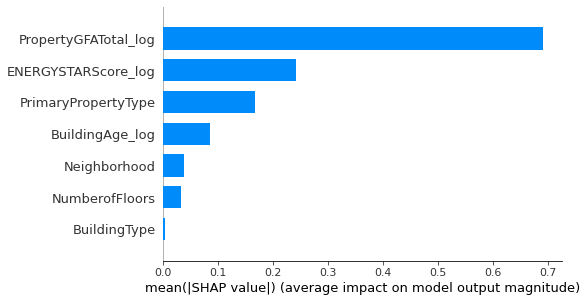

In [313]:
rf = RandomForestRegressor(max_depth=6, random_state=0, n_estimators=10)
rf.fit(X_train, y_train)

shap_values = shap.TreeExplainer(rf).shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar")

In [ ]:
"""

    Pour le random Forest Regressor,
        la surface : 'PropertyGFATotal_log' est la variable qui explique le plus la prédiction du modèle
    Il sera possible de réduire le nombre de variable et d'enlever, par exemple, 
        la variable 'BuildingType' qui a très peu d'impact dans la décision du modèle.

"""